## Week3 Lab section
- In this tutorial, we will import pretrained Generative model, and explore two important evaluation metrics for assessing the quality of generated images: the Inception Score (IS) and the Fréchet Inception Distance (FID). We will follow a step-by-step approach to achieve the following objectives:

1. Import Pretrained PGAN Model:
```python
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-512',
                       pretrained=True, useGPU=use_gpu)
```

2. Generate New image
```python
generated_images = model.test(noise)
```


3. Import Inception model (imageNet-1000)
```python
# Preprocessing steps
preprocess = Compose([
    Resize((299, 299)),  # Resize to 299x299
    ToTensor(),          # Convert to tensor
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])
```
```python
inception_model = inception_v3(pretrained=True, transform_input=False)
```
4. Calculate Inception Score (IS):
- Real vs. Fake
- Real vs. Real

5. Calculate Fréchet Inception Distance (FID):
- Real vs. Fake
- Real vs. Real

# Progressive Growing of GANs (PGAN)

*Author: FAIR HDGAN*

**High-quality image generation of fashion, celebrity faces**

_ | _
- | -
![alt](https://pytorch.org/assets/images/pgan_mix.jpg) | ![alt](https://pytorch.org/assets/images/pgan_celebaHQ.jpg)

In [63]:
import torch
import matplotlib.pyplot as plt
import torchvision
import os
import random
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
from torchvision.transforms import ToPILImage
from scipy.linalg import sqrtm
import torch.nn.functional as F
from scipy.stats import entropy
import torch.nn as nn
import numpy as np
import random

use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-512',
                       pretrained=True, useGPU=use_gpu)
# this model outputs 256 x 256 pixel images
# model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
#                        'PGAN', model_name='celebAHQ-256',
#                        pretrained=True, useGPU=use_gpu)

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


The input to the model is a noise vector of shape `(N, 512)` where `N` is the number of images to be generated.
It can be constructed using the function `.buildNoiseData`.
The model has a `.test` function that takes in the noise vector and generates images.

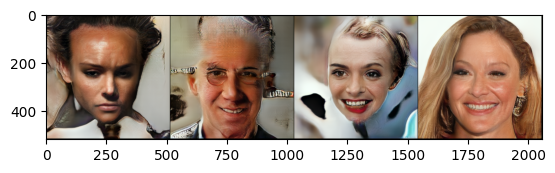

In [11]:
num_images = 4
noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = model.test(noise)

# let's plot these images using torchvision and matplotlib
grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
# plt.show()

In [12]:
# Generate images
num_images = 32
noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = model.test(noise)  # Assuming this returns a batch of tensors


### 1. Output of the Inception v3 model is typically used in IS, FID.
### 2. By default, it does not include the final softmax layer.
### 3. Therefore we manually add softmax layer to acquire probability outputs.

```pyton
probs = [F.softmax(pred, dim=0) for pred in preds]
```

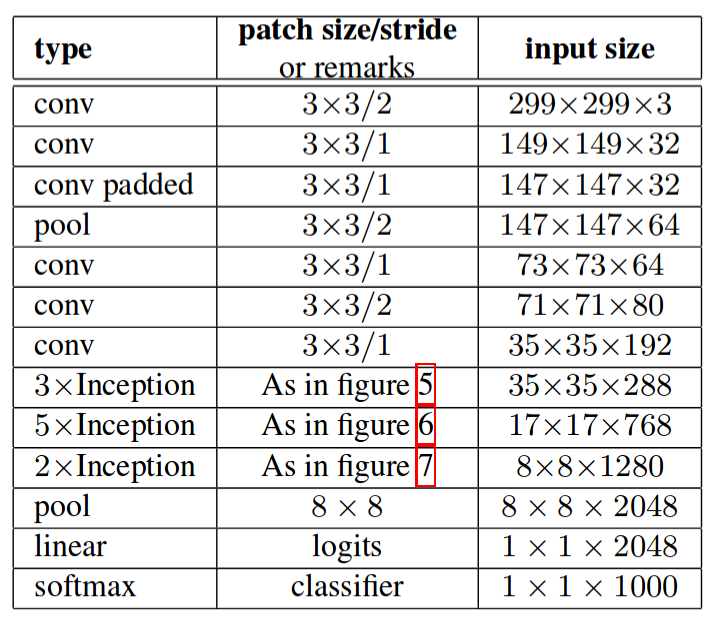

In [ ]:
for name, layer in inception_model.named_children():
    print(f"Layer Name: {name}")
    print(layer)
    print("\n")

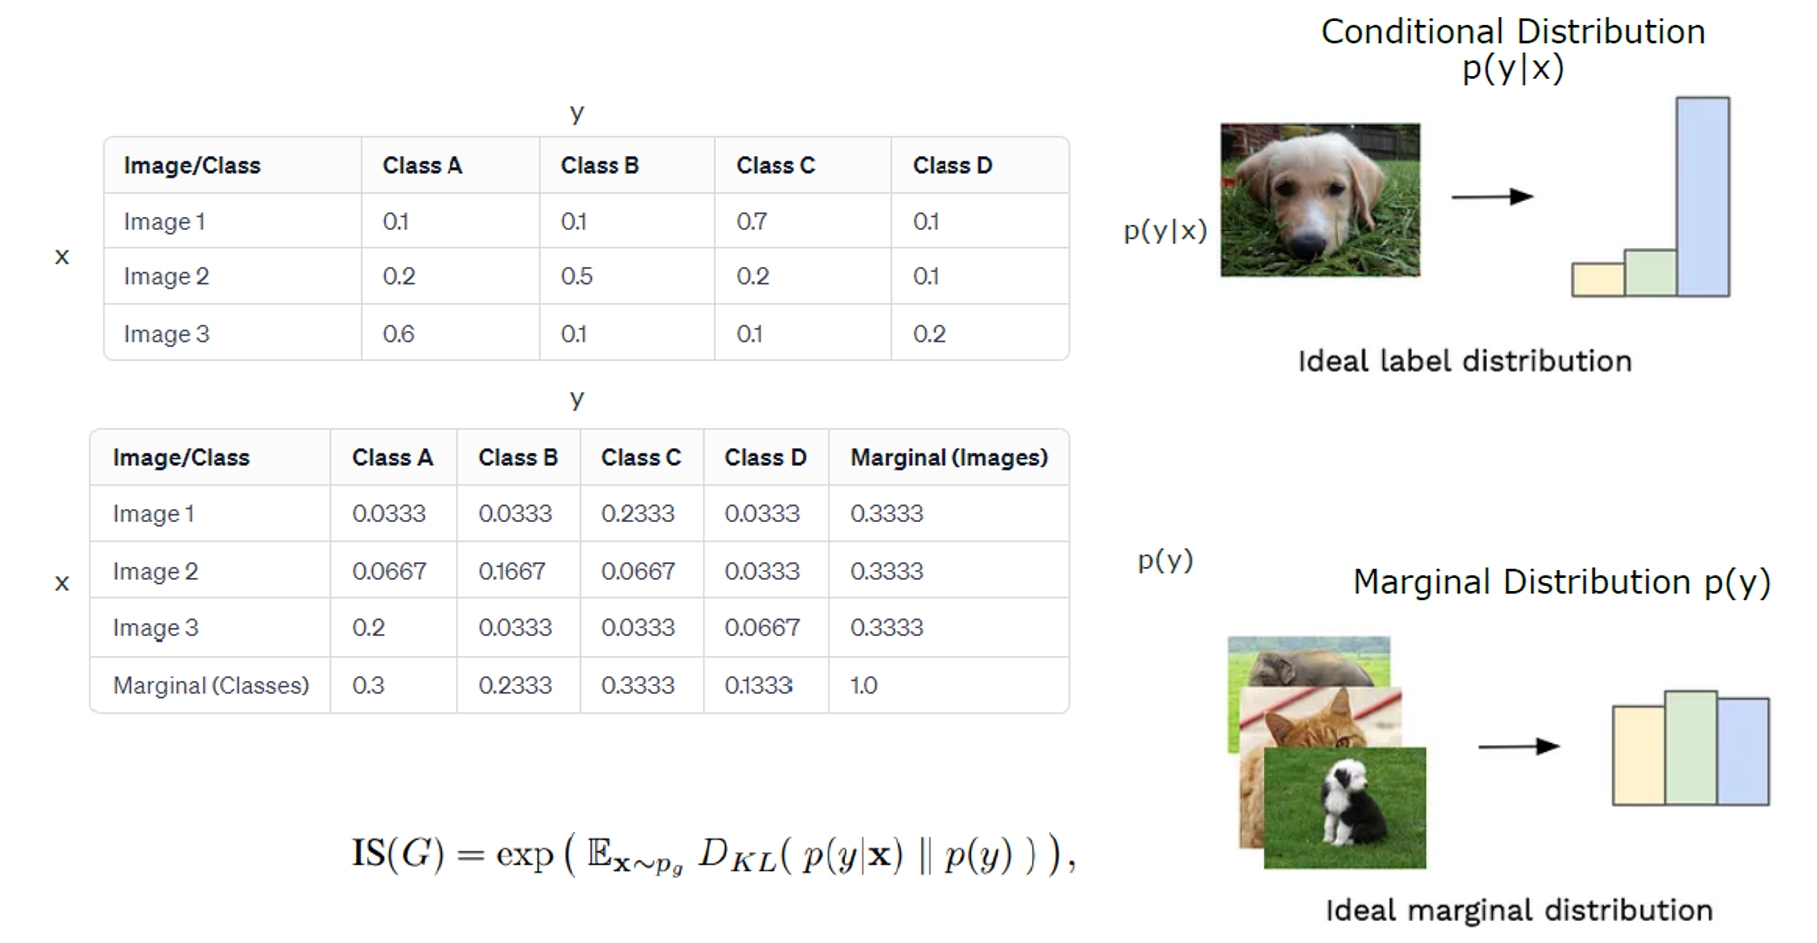

In [23]:
# Preprocessing steps
preprocess = Compose([
    Resize((299, 299)),  # Resize to 299x299
    ToTensor(),          # Convert to tensor
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

def calculate_inception_score(images, model):
    model.eval()

    preds = model(images)
    probs = F.softmax(preds, dim=1)  # Apply softmax across the classes dimension

    # Calculate the marginal distribution
    py = probs.mean(dim=0)  # Take the mean across the batch dimension

    # Compute the KL divergence and Inception Score
    scores = [entropy(prob.detach().numpy(), py.detach().numpy()) for prob in probs]

    # Calculate the Inception Score
    IS_mean = np.exp(np.mean(scores))

    return IS_mean


features = None
def calculate_fid(real_images, fake_images, model):
    model.eval()  # Set the model to evaluation mode
    # Function to hook the penultimate layer
    def get_penultimate_features(module, input, output):
        global features
        features = output.detach()

    # Register hook
    layer = model._modules.get('avgpool')
    hook = layer.register_forward_hook(get_penultimate_features)

    # Forward pass for fake images
    model(fake_images)
    feature_fake = features


    # Forward pass for real images
    model(real_images)
    feature_real = features

    # Remove the hook
    hook.remove()

    # Process features to get mean and covariance
    feature_fake = feature_fake.squeeze()
    feature_real = feature_real.squeeze()
    mu1, sigma1 = feature_fake.mean(axis=0), np.cov(feature_fake, rowvar=False)
    mu2, sigma2 = feature_real.mean(axis=0), np.cov(feature_real, rowvar=False)

    # Calculate FID
    ssdiff = torch.sum((mu1 - mu2)**2.0)
    covmean = sqrtm((sigma1 + 1e-6 * np.eye(sigma1.shape[0])).dot(sigma2 + 1e-6 * np.eye(sigma2.shape[0])))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


## We prepare the images for calculating the Inception Score (IS) and Fréchet Inception Distance (FID) using
- A set of generated images (referred to as "fake images")

- A set of real images from the Celebrity Face dataset, you can follow these steps:

In [17]:
# Generate images
num_images = 32
noise, _ = model.buildNoiseData(num_images) # model already has Noise generation functoin
print(noise.size())
generated_images = model.test(noise)  # Assuming this returns a batch of tensors

# Initialize an empty list to store processed images
fake_images = []

to_pil = ToPILImage()
# Preprocess each generated image
for img in generated_images:
    img_pil = to_pil(img)  # Convert tensor to PIL Image
    processed_img = preprocess(img_pil)  # Apply the preprocess directly on the tensor
    fake_images.append(processed_img)


torch.Size([32, 512])


## You can manually update this data to the colab: 32 images might be enough


In [117]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d farzadnekouei/50k-celebrity-faces-image-dataset
! unzip -q 50k-celebrity-faces-image-dataset.zip -d Kaggle

Saving kaggle.json to kaggle (1).json
50k-celebrity-faces-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Kaggle/Celebrity_Faces_Dataset/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Kaggle/Celebrity_Faces_Dataset/000002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## I used only 32 images but this number is insufficient to estimate covariance, in real experimental setting they use at least 50 - 1000 images in the single batch.



In [16]:
import os
import random
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image


# Set the directory where your images are located
image_directory = 'Kaggle/Celebrity_Faces_Dataset'  # Modify as needed

# Get a list of filenames in the directory
all_files = os.listdir(image_directory)

# Filter out non-image files if necessary
image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Randomly select 32 images
selected_images = image_files[:32]

real_images = []
for filename in selected_images:
    img_path = os.path.join(image_directory, filename)
    img = Image.open(img_path).convert('RGB')
    img = preprocess(img)
    real_images.append(img)

## Inception score for
- random image
- fake(generated) image
- real image

### Inceptoin score finds the differences between P(y|x), and P(Y), so higher number is better.

In [73]:
inception_model = inception_v3(pretrained=True, transform_input=False)

random_tensor = torch.randn(32, 3, 299, 299)
print(calculate_inception_score(random_tensor, inception_model))
print(calculate_inception_score(torch.stack(fake_images), inception_model))
print(calculate_inception_score(torch.stack(real_images), inception_model))

1.096405
1.5844784
3.47055


## FID score between real images and fake image
- FID assesses the similarity in feature distributions between real and fake images.
- It leverages a CNN model, typically Inception v3, to extract high-dimensional features from both image sets.
- If the generated (fake) images exhibit feature patterns similar to those in real images, as encoded by the CNN's neurons, it implies a closer alignment in their feature distributions.
- Therefore, a lower FID score signifies greater similarity

In [74]:
model = inception_v3(pretrained=True)
print(calculate_fid(torch.stack(real_images), torch.stack(fake_images), model))
print(calculate_fid(torch.stack(real_images), torch.stack(real_images), model))

tensor(299.7365)
tensor(-0.0041)


If you want to train your own Progressive GAN and other GANs from scratch, have a look at [PyTorch GAN Zoo](https://github.com/facebookresearch/pytorch_GAN_zoo).

### Model Description

Progressive Growing of GANs is a method developed by Karras et. al. [1] in 2017 allowing generation of high resolution images. To do so, the generative network is trained slice by slice. At first the model is trained to build very low resolution images, once it converges, new layers are added and the output resolution doubles. The process continues until the desired resolution is reached.

### References

[1] Tero Karras et al, "Progressive Growing of GANs for Improved Quality, Stability, and Variation" https://arxiv.org/abs/1710.10196

## Task - Utilize a Pretrained Generative Model to Create Images and Evaluate the images with IS and FID score

- Import any pretrained generative models (including ~one diffusion model) and then generate a set of images (up to 32).
- you can even use your model (or uploaded mode by instructor) from the prevoius homework
- FID Score Calculation: For the Fréchet Inception Distance (FID) evaluation, obtain a sample of real images from the same domain as the one on which your model was trained. If accessing such a dataset is challenging, you may alternatively use a relevant subset from a standard dataset like ImageNet or CelebA (less than 100 images).
- Flexibility in Implementation: If the provided code here does not align well with your chosen model, feel free to adapt or source alternative code as needed to facilitate the calculations.

#### If you couldn't finish the homework due to many reason (limitation of the resource, unresolved error), then just submit your last update, and describe what you have tried, and what was the current issue (problem). 

------------

# Optional Task (1 Point): Advanced Evaluation Metrics for Image Generation

## Task Description

In this optional task, you will **extend the evaluation of image generation models** by introducing **additional evaluation metrics beyond the basic ones**.

---

## Requirements

### 1. Add Additional Metrics
Add **at least two additional evaluation metrics**.
For examples: 

- **Unconditional quality & diversity**
  - Examples: FID, KID, CMMD
- **Perceptual fidelity**
  - Examples: LPIPS, GLIPS
- **Text / condition alignment**
  - Examples: CLIP-based metrics, VIEScore

or any advanced metrics in the research field. 

---

### 2. Detailed Description of Each Added Metric
For **each newly added metric**, provide the following information:

- **Metric name**
- **Definition** (what the metric measures)
- **Mathematical formulation** (formula or core equation)
- **Strengths** (advantages)
- **Limitations** (weaknesses or known issues)
---

### 3. Model Performance Comparison Table
Create a **comparison table** that reports model performance across **all evaluation metrics**, including:

- Existing metrics (e.g., FID, LPIPS, CLIP score)
- Newly added metrics

#### Table requirements:
- Rows: different models
- Columns: evaluation metrics
- Clearly indicate whether **higher (↑)** or **lower (↓)** values are better

Example structure:

| Model | FID ↓ | KID ↓ | CMMD ↓ | LPIPS ↓ | GLIPS ↑ | CLIP Score ↑ | VIEScore ↑ |
|------|------|------|-------|--------|---------|-------------|------------|
| Model A |  |  |  |  |  |  |  |
| Model B |  |  |  |  |  |  |  |
| Model C |  |  |  |  |  |  |  |




Write your codes here